In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score
import os
import pandas as pd

# Crear un directorio para guardar los gráficos
output_dir = "knn_results"
os.makedirs(output_dir, exist_ok=True)

# Función para generar datos de dos clases
def generar_datos(means_class0, means_class1, covs_class0, covs_class1, n_samples_class0, n_samples_class1):
    X0 = np.random.multivariate_normal(means_class0, covs_class0, n_samples_class0)
    X1 = np.random.multivariate_normal(means_class1, covs_class1, n_samples_class1)
    X = np.vstack((X0, X1))
    y = np.hstack((np.zeros(n_samples_class0), np.ones(n_samples_class1)))
    return X, y

# Función para evaluar modelos KNN y calcular métricas
def evaluar_modelos_knn(X_train, X_test, y_train, y_test, k_values):
    metrics_data = []
    roc_results = {}
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        y_scores = knn.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        auc = roc_auc_score(y_test, y_scores)
        roc_results[k] = (fpr, tpr, auc)

        # Calcular sensibilidad, especificidad y F1
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = round(tp / (tp + fn), 2)
        specificity = round(tn / (tn + fp), 2)
        f1 = round(f1_score(y_test, y_pred), 2)
        auc = round(auc, 2)

        # Almacenar los datos en la lista
        metrics_data.append([k, sensitivity, specificity, f1, auc])

    return metrics_data, roc_results

# Función para graficar los resultados
def graficar_resultados(X0, X1, metrics_data, roc_results, dataset_idx):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    axs[0].scatter(X0[:, 0], X0[:, 1], alpha=0.5, label='Clase 0')
    axs[0].scatter(X1[:, 0], X1[:, 1], alpha=0.5, label='Clase 1')
    axs[0].set_title(f'Distribución de las dos clases - Juego {dataset_idx + 1}')
    axs[0].set_xlabel('Característica 1')
    axs[0].set_ylabel('Característica 2')
    axs[0].legend()

    for k, (fpr, tpr, auc) in roc_results.items():
        axs[1].plot(fpr, tpr, label=f'K={k} (AUC = {auc:.2f})')

    axs[1].plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
    axs[1].set_title(f'Curvas ROC para modelos KNN - Juego {dataset_idx + 1}')
    axs[1].set_xlabel('Tasa de Falsos Positivos')
    axs[1].set_ylabel('Tasa de Verdaderos Positivos')
    axs[1].legend(loc='best')

    # Añadir una tabla con los valores de sensibilidad, especificidad, F1 y AUC
    table_data = [['K', 'Sensibilidad', 'Especificidad', 'F1', 'AUC']] + metrics_data
    table = axs[1].table(cellText=table_data, loc='bottom', cellLoc='center', bbox=[0.0, -0.5, 1.0, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Ajustar el diseño y guardar el gráfico
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'knn_{dataset_idx + 1}.png'), bbox_inches='tight')
    plt.close()

# Función principal para ejecutar el análisis
def ejecutar_analisis(n_datasets, n_samples_class0, n_samples_class1, k_values, means_class0, means_class1, covs_class0, covs_class1):
    all_metrics = []
    for dataset_idx in range(n_datasets):
        # Obtener medias y covarianzas para el juego actual
        mean_class0 = means_class0[dataset_idx]
        mean_class1 = means_class1[dataset_idx]
        cov_class0 = covs_class0[dataset_idx]
        cov_class1 = covs_class1[dataset_idx]

        # Generar datos y dividir en entrenamiento y prueba
        X, y = generar_datos(mean_class0, mean_class1, cov_class0, cov_class1, n_samples_class0, n_samples_class1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

        # Evaluar modelos y obtener métricas
        metrics_data, roc_results = evaluar_modelos_knn(X_train, X_test, y_train, y_test, k_values)
        all_metrics.extend([[dataset_idx + 1] + row for row in metrics_data])

        # Graficar resultados
        X0, X1 = X[y == 0], X[y == 1]
        graficar_resultados(X0, X1, metrics_data, roc_results, dataset_idx)

    # Guardar todas las métricas en un DataFrame y visualizar
    metrics_df = pd.DataFrame(all_metrics, columns=['Dataset', 'K', 'Sensibilidad', 'Especificidad', 'F1', 'AUC'])
    metrics_df.to_csv(os.path.join(output_dir, 'metrics_summary.csv'), index=False)
    print(metrics_df)

# Parámetros
n_datasets = 10
n_samples_class0 = 1000
n_samples_class1 = 1000
n_features = 2
k_values = [3, 5, 7, 9]

# Crear arreglos de medias y covarianzas predefinidas para cada clase
means_class0 = [
    np.array([0, 0]),  # Clases completamente separadas
    np.array([1, 1]),
    np.array([2, 2]),
    np.array([3, 3]),
    np.array([4, 4]),
    np.array([4.5, 4.5]),
    np.array([5, 5]),
    np.array([5, 5.5]),
    np.array([5, 6]),
    np.array([5, 5])  # Clases completamente superpuestas
]

means_class1 = [
    np.array([10, 10]),  # Clases completamente separadas
    np.array([9, 9]),
    np.array([8, 8]),
    np.array([7, 7]),
    np.array([6, 6]),
    np.array([5.5, 5.5]),
    np.array([5, 5]),
    np.array([5, 4.5]),
    np.array([5, 4]),
    np.array([5, 5])  # Clases completamente superpuestas
]

covs_class0 = [
    np.array([[1, 0.5], [0.5, 1]]) for _ in range(n_datasets)
]

covs_class1 = [
    np.array([[1, -0.5], [-0.5, 1]]) for _ in range(n_datasets)
]

# Ejecutar análisis
ejecutar_analisis(n_datasets, n_samples_class0, n_samples_class1, k_values, means_class0, means_class1, covs_class0, covs_class1)


    Dataset  K  Sensibilidad  Especificidad    F1   AUC
0         1  3          1.00           1.00  1.00  1.00
1         1  5          1.00           1.00  1.00  1.00
2         1  7          1.00           1.00  1.00  1.00
3         1  9          1.00           1.00  1.00  1.00
4         2  3          1.00           1.00  1.00  1.00
5         2  5          1.00           1.00  1.00  1.00
6         2  7          1.00           1.00  1.00  1.00
7         2  9          1.00           1.00  1.00  1.00
8         3  3          1.00           1.00  1.00  1.00
9         3  5          1.00           1.00  1.00  1.00
10        3  7          1.00           1.00  1.00  1.00
11        3  9          1.00           1.00  1.00  1.00
12        4  3          1.00           0.99  1.00  1.00
13        4  5          1.00           0.99  1.00  1.00
14        4  7          1.00           0.99  1.00  1.00
15        4  9          1.00           0.99  1.00  1.00
16        5  3          0.93           0.91  0.9

   Dataset  K  Sensibilidad  Especificidad   F1  AUC
0        1  3           1.0            1.0  1.0  1.0
1        1  5           1.0            1.0  1.0  1.0
2        1  7           1.0            1.0  1.0  1.0
3        1  9           1.0            1.0  1.0  1.0
4        2  3           1.0            1.0  1.0  1.0


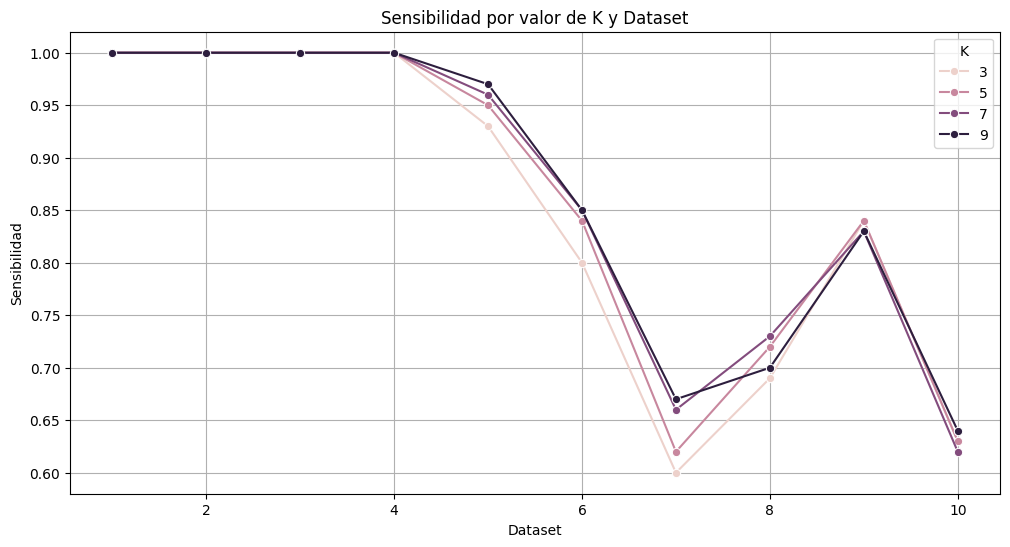

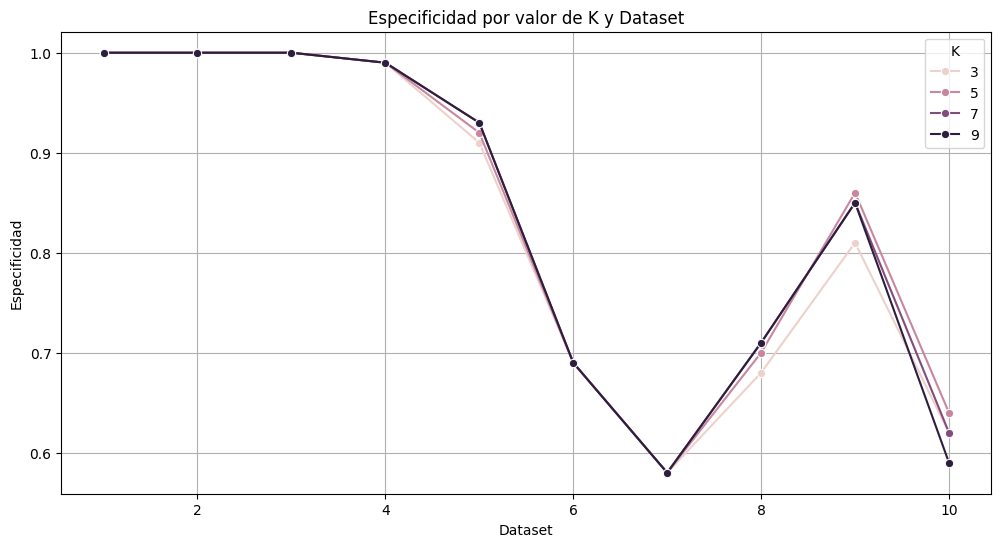

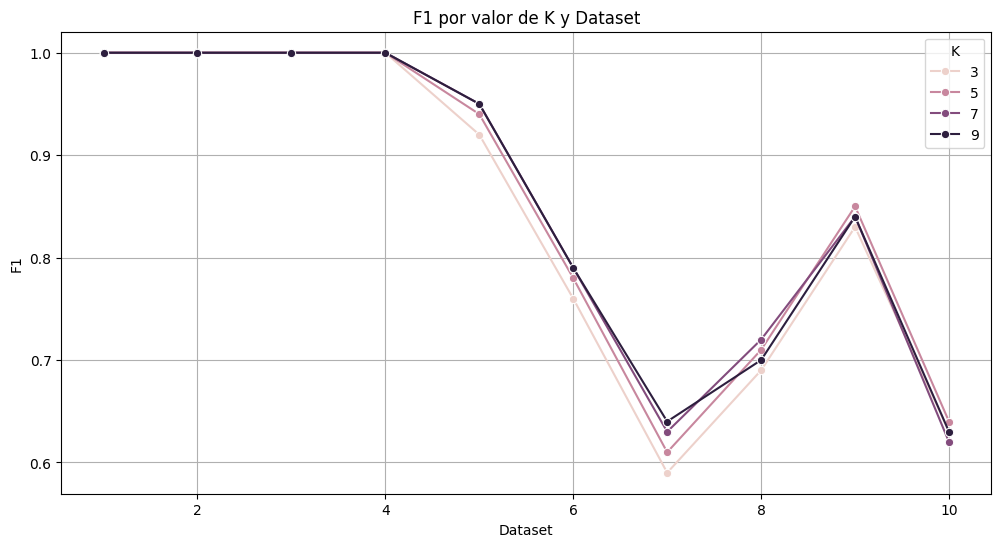

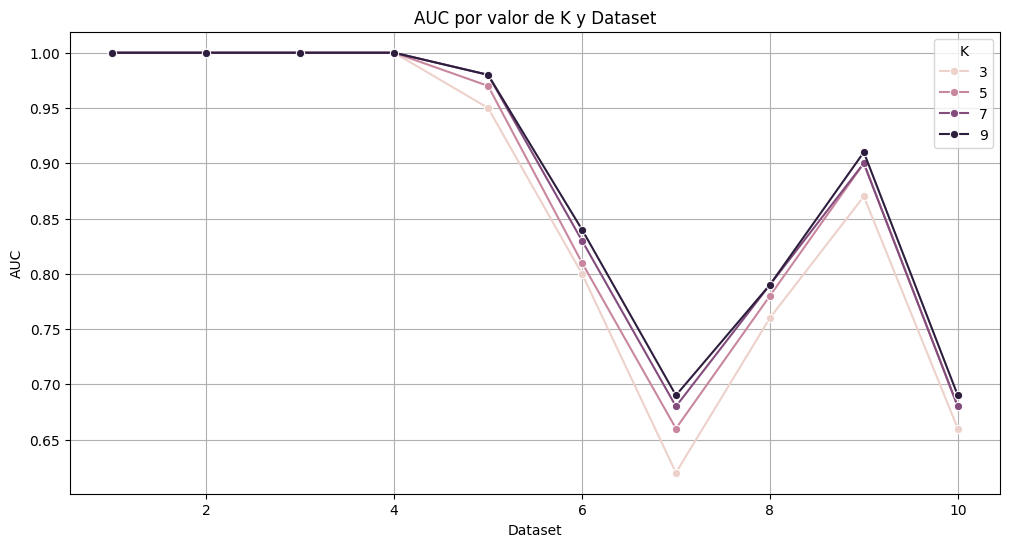

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo CSV con las métricas
metrics_df = pd.read_csv('knn_results/metrics_summary.csv')

# Mostrar las primeras filas del DataFrame para verificar el contenido
print(metrics_df.head())

# Función para graficar el comportamiento de las métricas
def graficar_metricas(metrics_df):
    # Gráfico de sensibilidad para cada valor de K
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=metrics_df, x='Dataset', y='Sensibilidad', hue='K', marker='o')
    plt.title('Sensibilidad por valor de K y Dataset')
    plt.xlabel('Dataset')
    plt.ylabel('Sensibilidad')
    plt.legend(title='K')
    plt.grid(True)
    plt.savefig('knn_results/sensibilidad_plot.png')
    plt.show()

    # Gráfico de especificidad para cada valor de K
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=metrics_df, x='Dataset', y='Especificidad', hue='K', marker='o')
    plt.title('Especificidad por valor de K y Dataset')
    plt.xlabel('Dataset')
    plt.ylabel('Especificidad')
    plt.legend(title='K')
    plt.grid(True)
    plt.savefig('knn_results/especificidad_plot.png')
    plt.show()

    # Gráfico de F1 para cada valor de K
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=metrics_df, x='Dataset', y='F1', hue='K', marker='o')
    plt.title('F1 por valor de K y Dataset')
    plt.xlabel('Dataset')
    plt.ylabel('F1')
    plt.legend(title='K')
    plt.grid(True)
    plt.savefig('knn_results/f1_plot.png')
    plt.show()

    # Gráfico de AUC para cada valor de K
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=metrics_df, x='Dataset', y='AUC', hue='K', marker='o')
    plt.title('AUC por valor de K y Dataset')
    plt.xlabel('Dataset')
    plt.ylabel('AUC')
    plt.legend(title='K')
    plt.grid(True)
    plt.savefig('knn_results/auc_plot.png')
    plt.show()

# Ejecutar la función para graficar las métricas
graficar_metricas(metrics_df)